# QC report: HILICpos Rafi only samples (R5pos, R5neg & Naive)
- Minghao Gong; 07/27/2022
- This notebook specifically fits Asari run
- run with deduplicated samples (technical removed)

# Load libraries

In [31]:
# Let the middle rows included.
options(repr.matrix.max.rows=600, repr.matrix.max.cols=200)

In [32]:
#load libraries 
shhh <- suppressPackageStartupMessages # It's a library, so shhh!
shhh(library(FactoMineR))
shhh(library(factoextra))
shhh(library(reshape2))
shhh(library(tidyverse))
shhh(library(RColorBrewer))
shhh(library(gridExtra))
shhh(library(pheatmap))
library(repr)#jupyter notebook R ; image manipulation 
#shhh(library(devtools))
#install_github("vqv/ggbiplot")
shhh(library(ggbiplot))
options(warn=-1)#dont show warnings in Output 
options(digits = 14) # Or any higher number; fixing decimal places

library("rjson")

source('./utilis/utlis_MQC.R')

# Read tables

## load Metadata & feature table
- Here first use the peak Area table

# !!! What meta/feature/filtered tables in use?
- HILICpos

In [33]:
meta_path <- "../../input/sequence_file/clean_deduplicated_meta_df.csv"
featab_path <- "../../output/preprocessing_97/groupFil0.3_HILICpos_featab.csv"


#### Read metadata table

In [34]:
# metadata information
meta_df <- read_csv(meta_path)

Rows: 9 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): tID_dedup, class, biological_samples
dbl (1): cell_number

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [35]:
head(meta_df)

tID_dedup,class,biological_samples,cell_number
<chr>,<chr>,<chr>,<dbl>
Naive_1,Naive,Yes,300
Naive_2,Naive,Yes,300
Naive_3,Naive,Yes,300
R5neg_1,R5neg,Yes,655
R5neg_2,R5neg,Yes,687
R5neg_3,R5neg,Yes,865


#### Read in the feature table
- Of note, since it is using tibble, row.names are suppressed; `COMP ID` comes as the first columns

In [36]:
asari_df <- read_delim(featab_path,delim = ',')

Rows: 2771 Columns: 29
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): id_number
dbl (28): mz, rtime, rtime_left_base, rtime_right_base, parent_masstrack_id,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [37]:
asari2data_feat_df_regExpr <- function(asari_df,regExpr_sample_cols) {
    sample_col_index = grep(regExpr_sample_cols,colnames(asari_df))
    featab_df = asari_df[,c(1,sample_col_index)]
    return(featab_df)
}

asari2data_feat_df_index <- function(asari_df,end_index = 11) {
    featab_df = asari_df[,c(1,end_index:ncol(asari_df))]
    return(featab_df)
}

In [38]:
featab_df = asari2data_feat_df_regExpr(asari_df,"Naive\\_[0-9]|R5pos\\_[0-9]|R5neg\\_[0-9]")

In [39]:
dim(featab_df)

[1] 2771   10

In [40]:
head(featab_df) # examine the table

id_number,Naive_1,Naive_2,Naive_3,R5neg_1,R5neg_2,R5neg_3,R5pos_1,R5pos_2,R5pos_3
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F6,163014,185168,311919,253136.5,218917.5,346558.5,133599,101565,110948
F7,134222,44310,101329,248979.0,91793.5,167454.0,80291,136212,83206
F13,951141,1549923,2303649,1573781.0,1631864.0,1939811.5,1073833,1293960,2205156
F18,1548625,1551932,1486245,1650246.0,1840498.5,2827805.0,3623620,1749825,1248065
F31,NA,453107,NA,713299.5,669238.0,739421.0,NA,NA,NA
F32,NA,93720,NA,511237.0,353941.5,582759.5,NA,NA,NA


### subset metadatabased on feature table
- make sure the below list is matchable at least subsets

In [41]:
colnames(featab_df)

[1] "id_number" "Naive_1"   "Naive_2"   "Naive_3"   "R5neg_1"   "R5neg_2"  
 [7] "R5neg_3"   "R5pos_1"   "R5pos_2"   "R5pos_3"

In [42]:
pull(meta_df['tID_dedup']) # tibble column needs to pull out into vector

[1] "Naive_1" "Naive_2" "Naive_3" "R5neg_1" "R5neg_2" "R5neg_3" "R5pos_1"
[8] "R5pos_2" "R5pos_3"

In [43]:
meta_df = meta_df[pull(meta_df['tID_dedup']) %in% colnames(featab_df),]

In [44]:
dim(meta_df)

[1] 9 4

In [45]:
head(meta_df)

tID_dedup,class,biological_samples,cell_number
<chr>,<chr>,<chr>,<dbl>
Naive_1,Naive,Yes,300
Naive_2,Naive,Yes,300
Naive_3,Naive,Yes,300
R5neg_1,R5neg,Yes,655
R5neg_2,R5neg,Yes,687
R5neg_3,R5neg,Yes,865


#### procedure for preoprocessing of data
- log2-transformation (currently the missing data is denoted by NA)
- Analysis the TIC
- Correlation heatmap

In [46]:
log2transform <- function(featab_df) {
    featab_df[featab_df == 0] = NA
    featab_df.log <- cbind(featab_df[,1],log2(featab_df[, 2:ncol(featab_df)])) # no need to add +1
    # featab_df.log[is.na(featab_df.log)] = 0
    return(featab_df.log)
}

In [47]:
# separate the annotation and feature values part and do log2 conversion
featab_df.log <- log2transform(featab_df) # no need to add +1
head(featab_df.log)

,id_number,Naive_1,Naive_2,Naive_3,R5neg_1,R5neg_2,R5neg_3,R5pos_1,R5pos_2,R5pos_3
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,F6,17.314636346030,17.498475273736,18.250811909069,17.949556020496,17.740027760861,18.402739378130,17.027549683593,16.632043799522,16.759524135518
2,F7,17.034261633975,15.435344706373,16.628687601870,17.925664538523,16.486104377962,17.353405312776,16.292950661401,17.055494281883,16.344399944672
3,F13,19.859299700825,20.563765113677,21.135489483789,20.585803365445,20.638089397037,20.887485035537,20.034338215529,20.303361589519,21.072449289717
4,F18,20.562556406713,20.565633914599,20.503240525813,20.654249670478,20.811665143255,21.431251207423,21.789000240807,20.738779214664,20.251261641934
5,F31,NA,18.789492253497,NA,19.444148436716,19.352159839800,19.496036491948,NA,NA,NA
6,F32,NA,16.516069333750,NA,18.963632727359,18.433151403575,19.152541092437,NA,NA,NA


In [48]:
dim(featab_df.log)

[1] 2771   10

### Overall Density Distribution of data 
  

- first two columns are gona be mz and rt and rest should be the samples ; nothing else 

- two parameters needed : 
  - data : - Data can be log2(prefferably) /linear; if have nas will be imputed to calulate density
  
  - y_lim_param; to adjust height of y axis(desnity) in the plot; later to automate it may be 
  

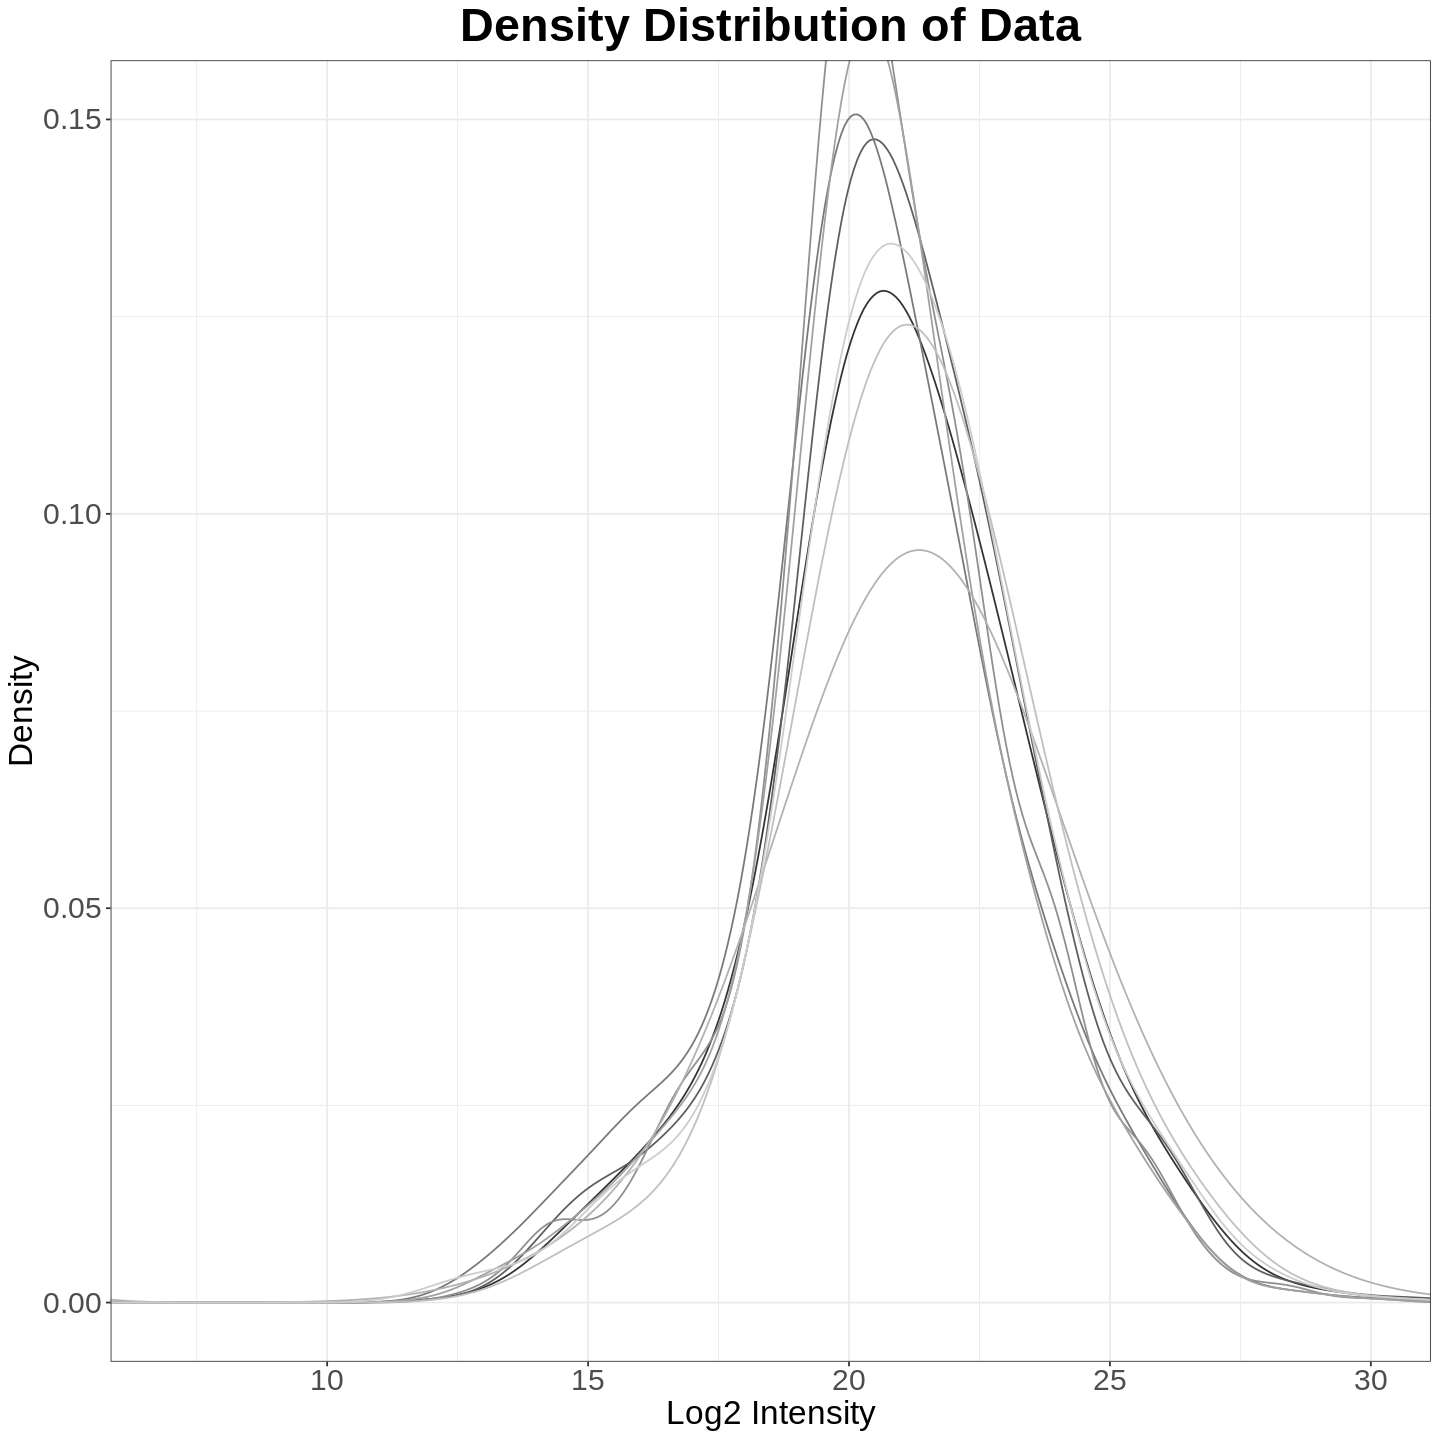

In [49]:
options(repr.plot.width=12, repr.plot.height=12, res=200)
suppressMessages(custom_density_plot(featab_df.log[,2:ncol(featab_df.log)], 
                                     y_lim_param=0.15))

### Mean TIC ACross Samples 

Input:

- data ; if nas ; willl be imputed for 0s within the function because we need to take into account the missing values in each sample to properly detect low intensity samples 
- optional ; metadata ; if present will factor color it ; if not then will not 


Note ; if x-axis need be changed for fontsize ; use   axis.title.x = element_text( size=16) in plotMeanTic function to control;

In [51]:
meta_df

tID_dedup,class,biological_samples,cell_number
<chr>,<chr>,<chr>,<dbl>
Naive_1,Naive,Yes,300
Naive_2,Naive,Yes,300
Naive_3,Naive,Yes,300
R5neg_1,R5neg,Yes,655
R5neg_2,R5neg,Yes,687
R5neg_3,R5neg,Yes,865
R5pos_1,R5pos,Yes,142
R5pos_2,R5pos,Yes,200
R5pos_3,R5pos,Yes,150


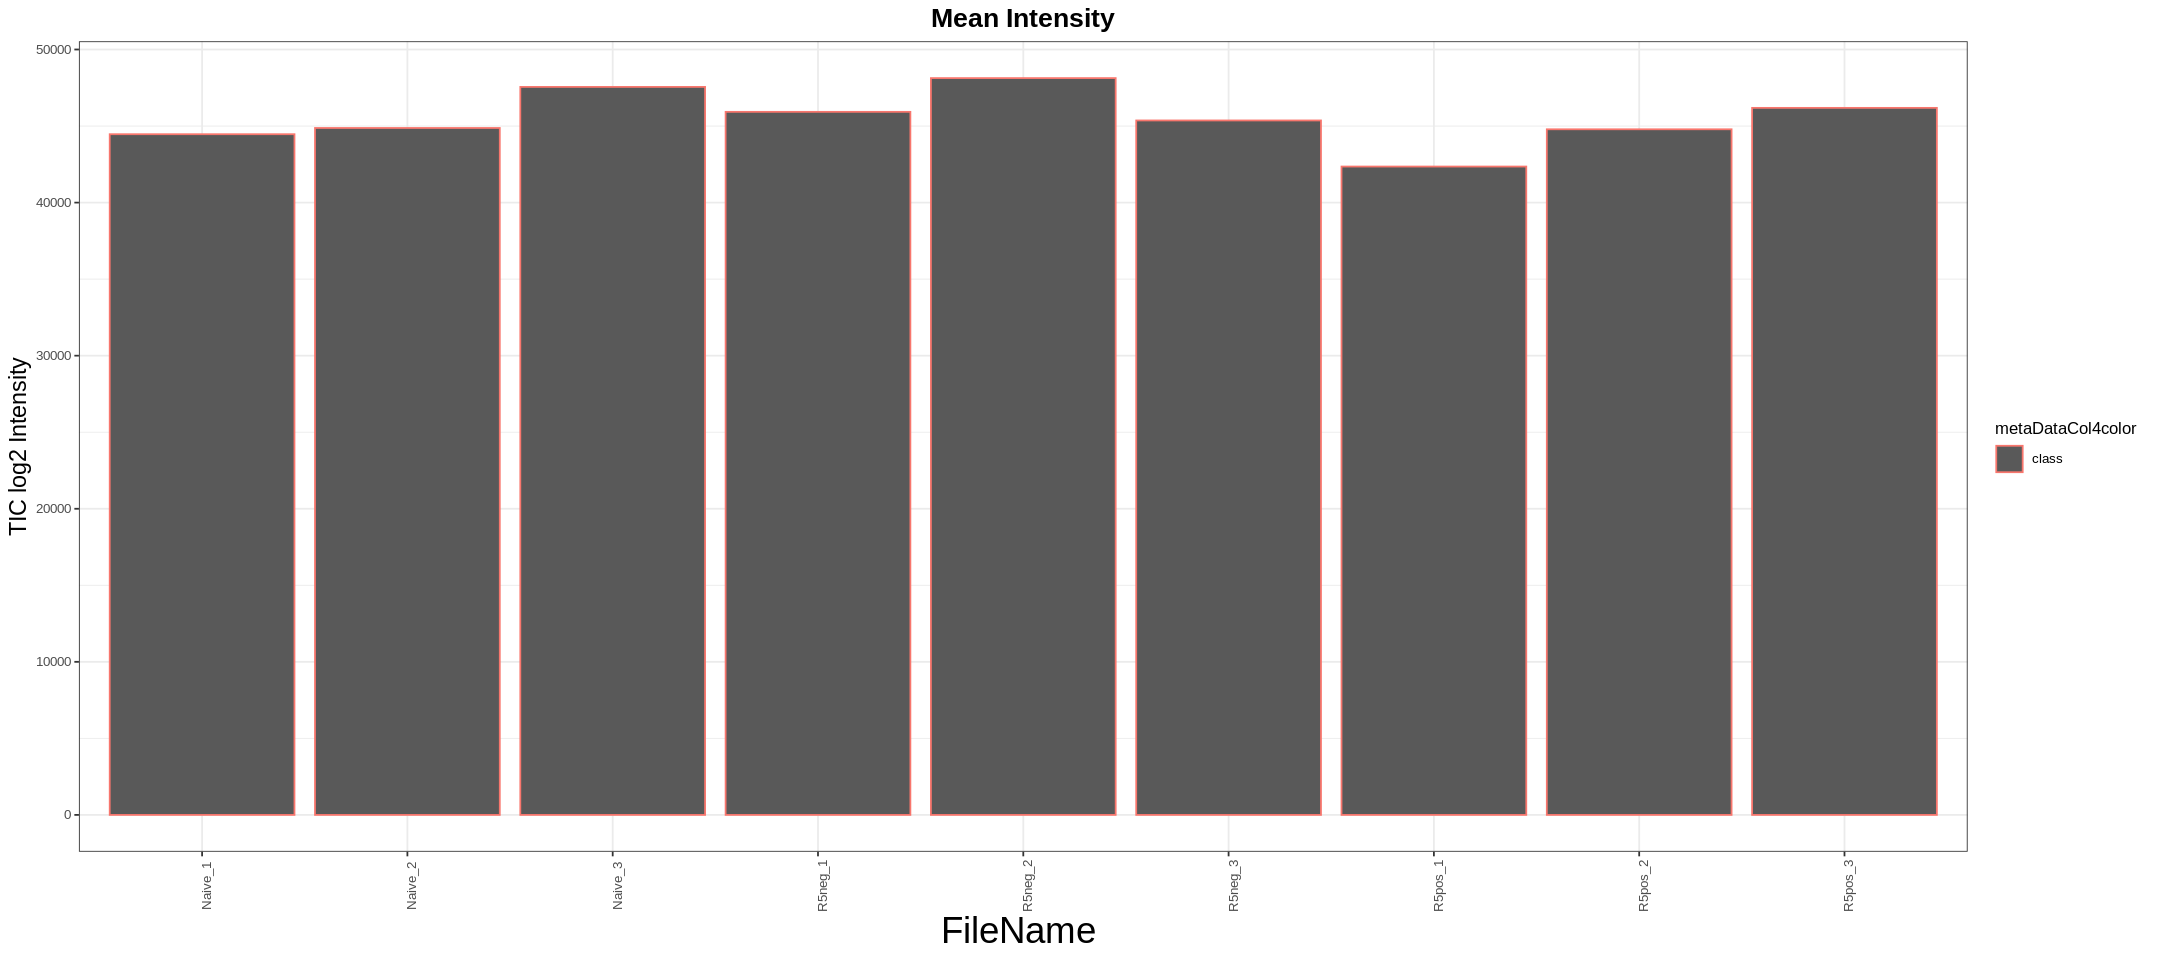

In [52]:
options(repr.plot.width=18, repr.plot.height=8, res=200)
suppressMessages(plotTIC(featab_df.log,meta_df,"tID_dedup","class"))
#control xaxis font size;axis.title.x = element_text( size=16)

## Decide SD cutoff for outliers by yourself if need be

In [53]:
get_TIC_outliers(featab_df.log,2)

columnsum,Sample.ID
<dbl>,<chr>


### Missing values plot 

Input:

- logged 2/linear scale  data with nas ; no imputation happening in the function as i am counting Nas 


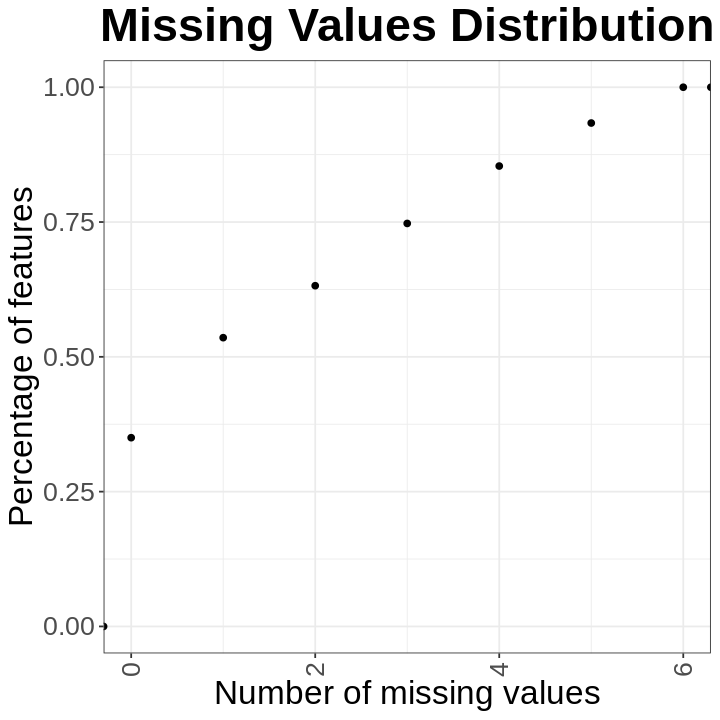

In [54]:
source('./utilis/utlis_MQC.R')
options(repr.plot.width=6, repr.plot.height=6, res=200)
plot_NA_cdf(featab_df.log, present_percentage = FALSE)

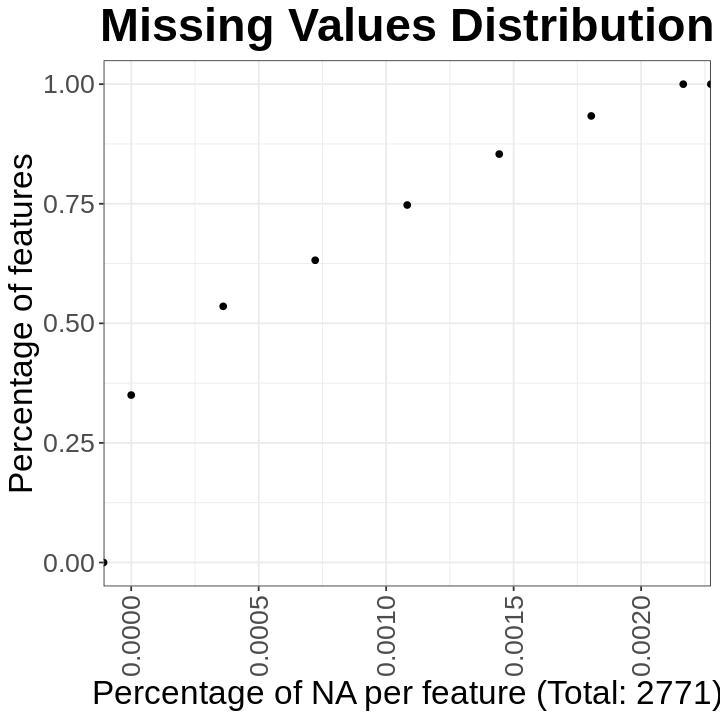

In [55]:
options(repr.plot.width=6, repr.plot.height=6, res=200)
plot_NA_cdf(featab_df.log, present_percentage = TRUE)

### Corelation bw samples 

In [56]:
# A function that help later step as correlation plot cannot handle very well with zero values
mssingValueAsNA <- TRUE # NA is good to skip this step
if (!mssingValueAsNA) {
    featab_df.log.NA <- featab_df.log
    featab_df.log.NA[featab_df.log == 0] <- NA  # Turn 0 into NA
    featab_df.log <- featab_df.log.NA
}

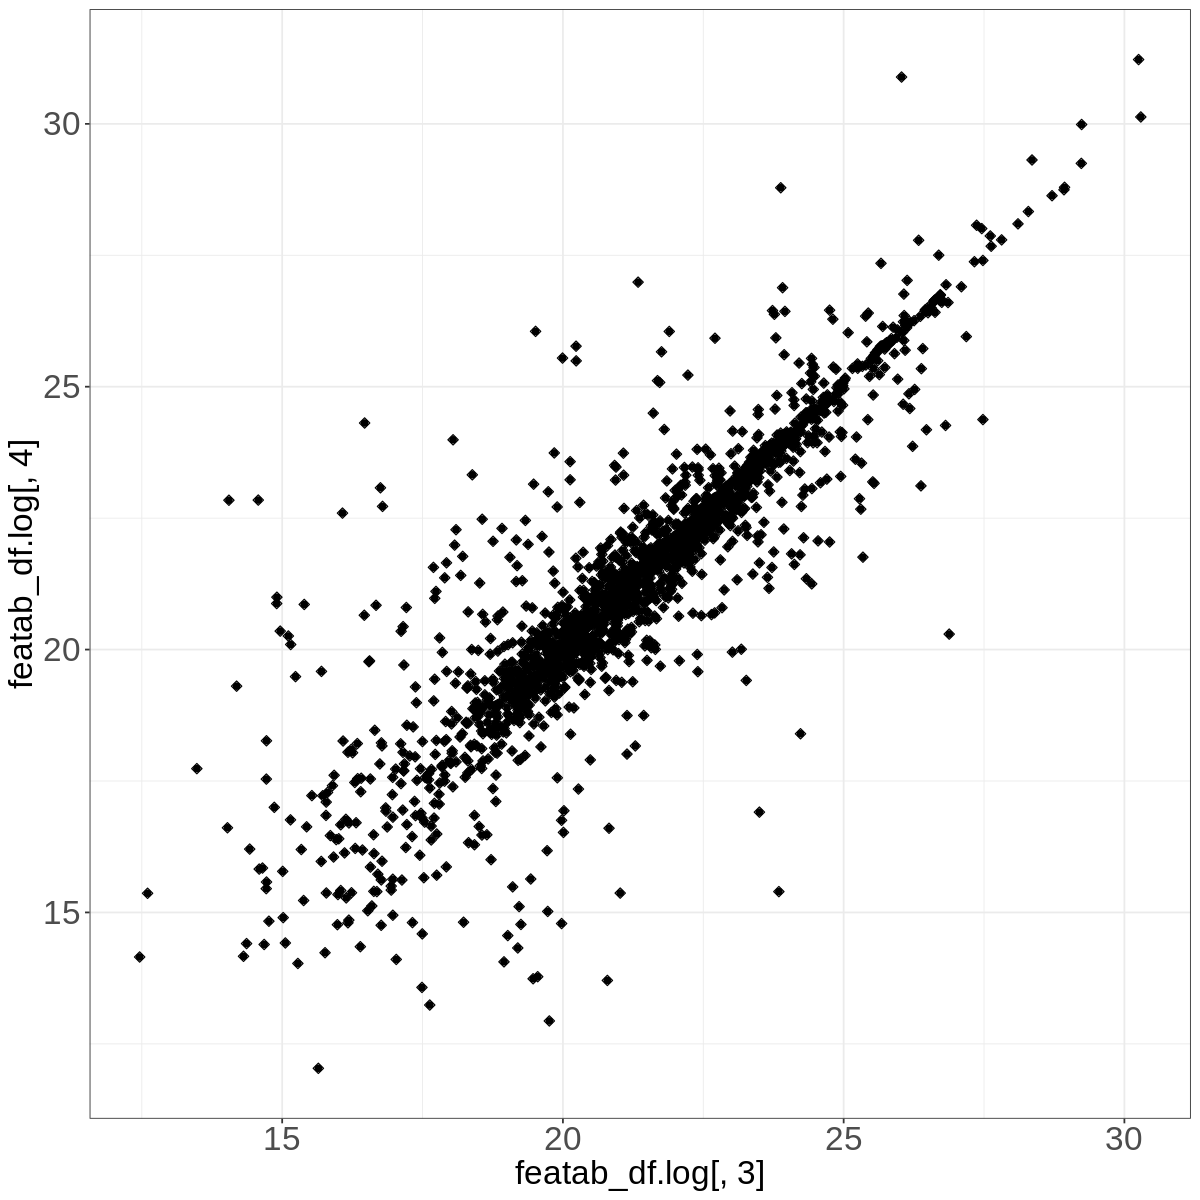

In [57]:
#options(repr.plot.width=16, repr.plot.height=20, res=200)
# reproducibility of injection replicates
#figure options ; change to the needs
options(repr.plot.width=10, repr.plot.height=10)
  ggplot(featab_df.log, aes(x=featab_df.log[,3], y=featab_df.log[,4])) + geom_point()+
  geom_point(size=2, shape=23) +# Change the point size, and shape
  theme_bw()+#axis settings 
    theme(axis.text=element_text(size=20))+
 #axis labels settings 
    theme(axis.title=element_text(size=20))

## Heatmap 

Input: 
- data; log2/linear scale data with nas 
- metadata is optional 
- metadata include what to colors.

WishList Note:  fix if metadata is not passed; debug

In [58]:
colnames(meta_df)

[1] "tID_dedup"          "class"              "biological_samples"
[4] "cell_number"

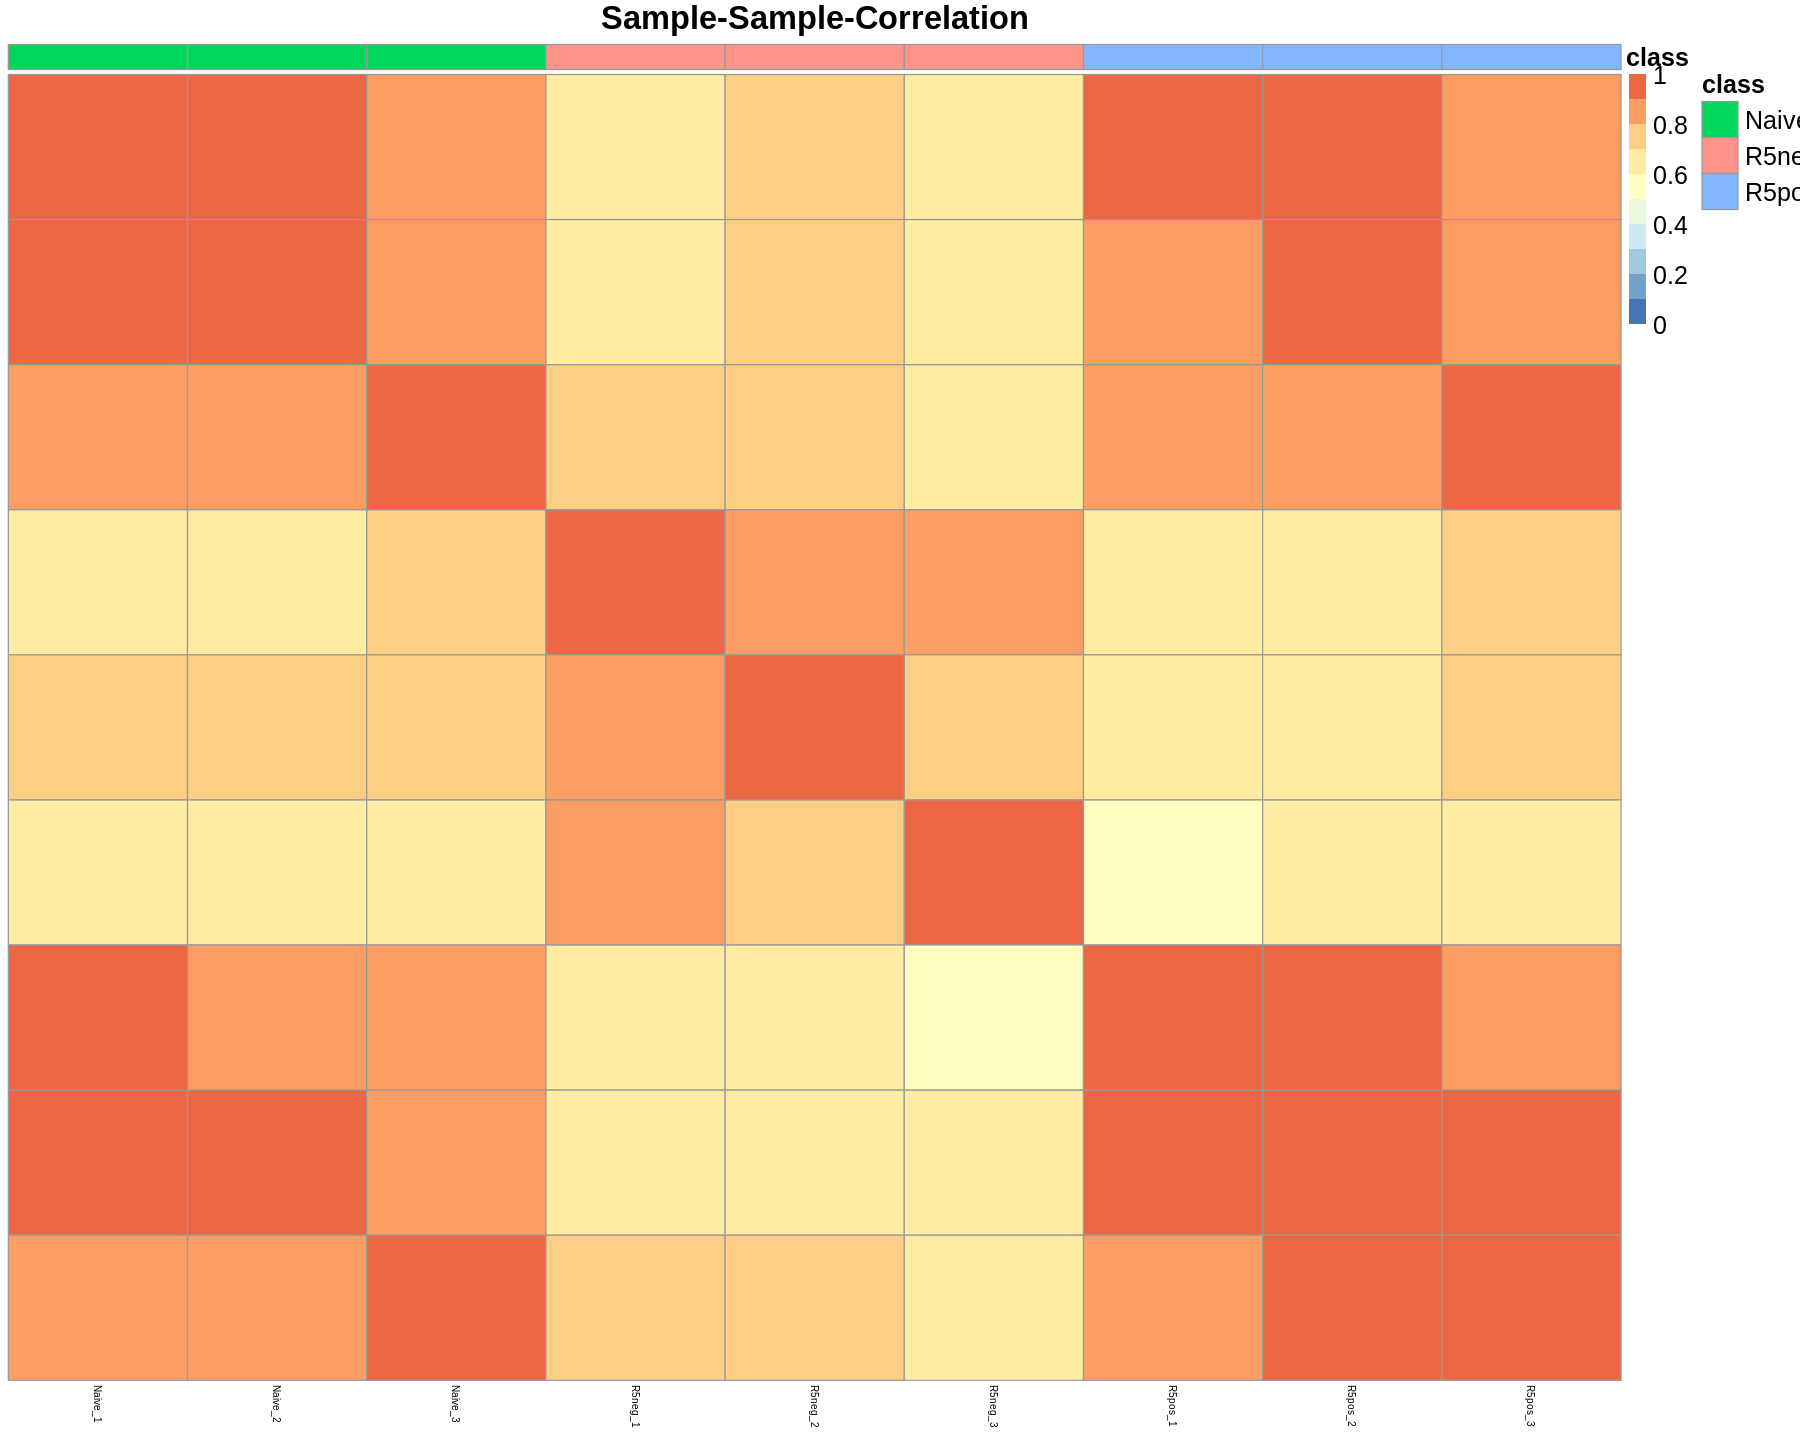

In [60]:
options(repr.plot.width=15, repr.plot.height=12, res=300)
suppressMessages(plot_heatmap(featab_df.log, meta_df, "tID_dedup","class"))

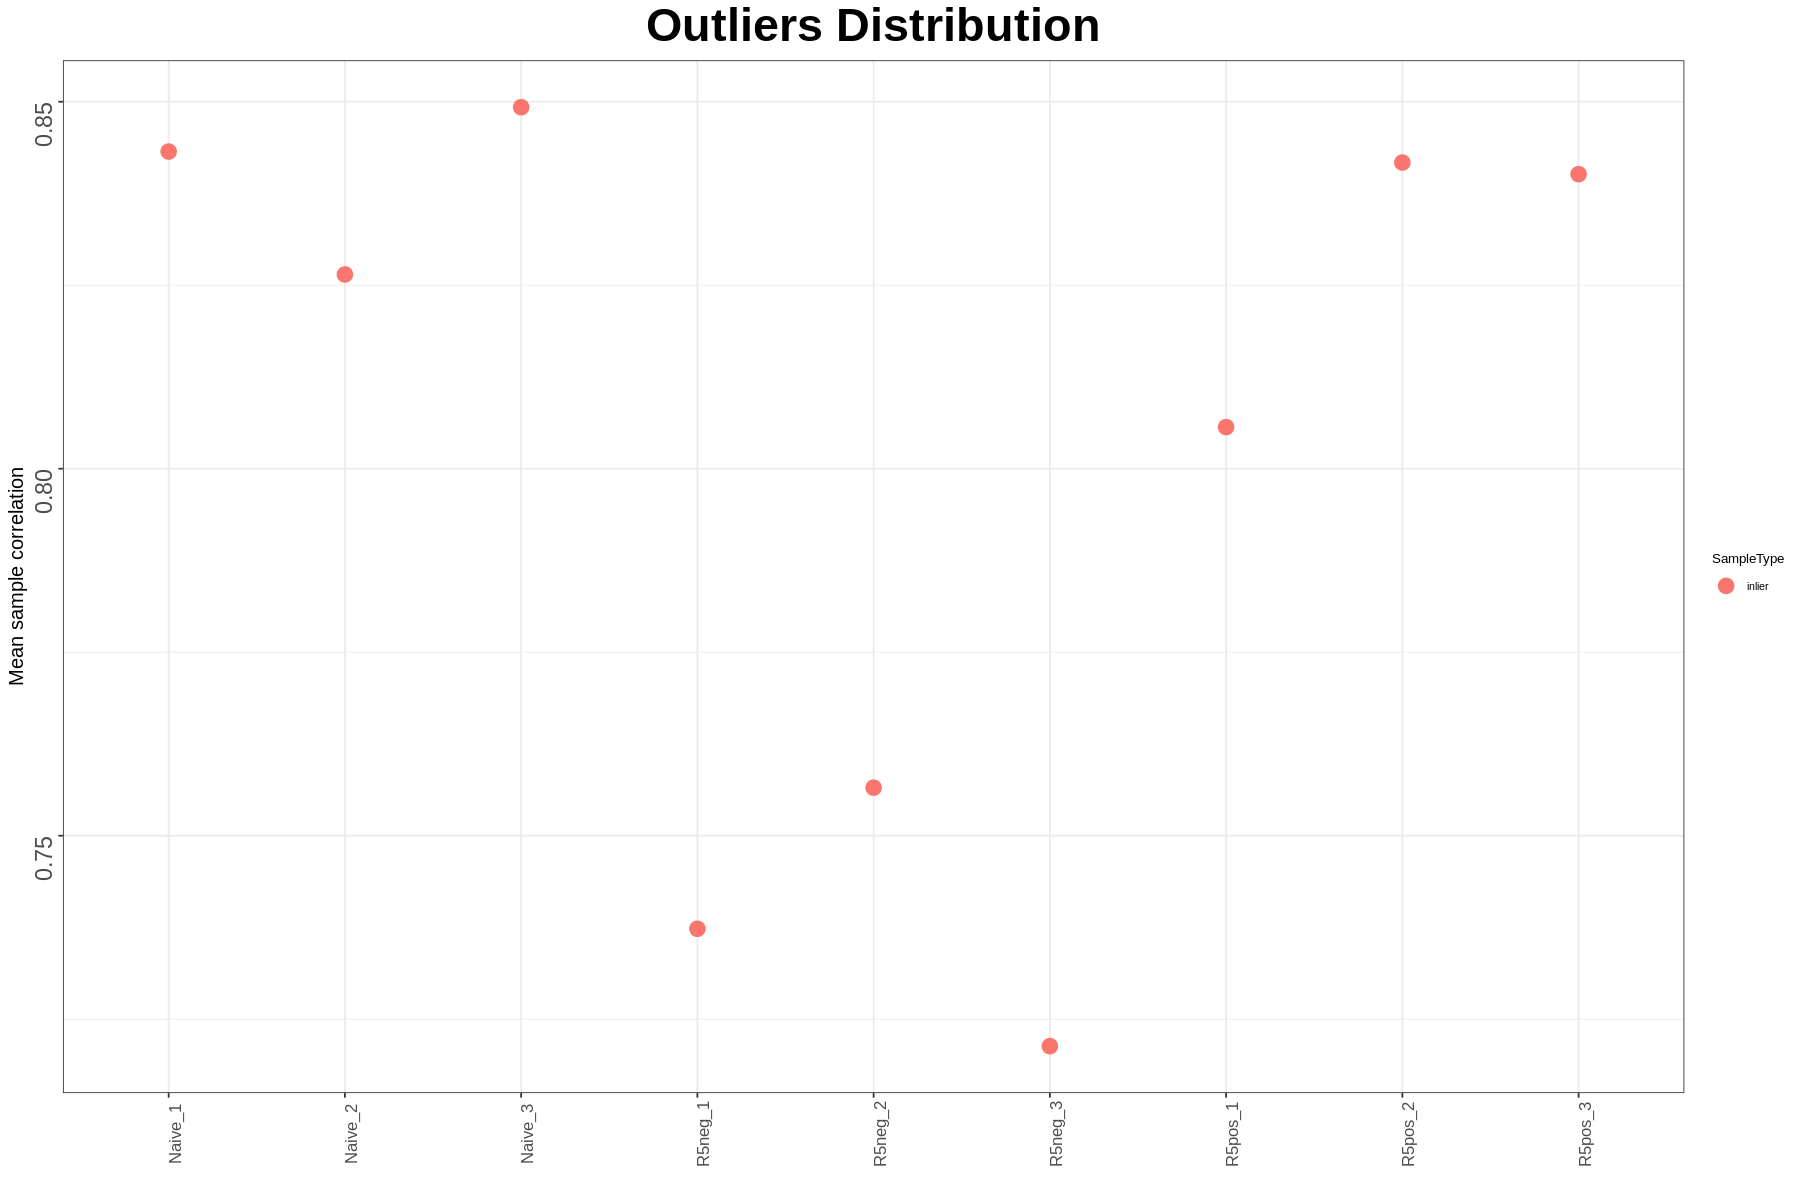

In [61]:
df.outliers <-  get_outliers_heatmap(featab_df.log)
options(repr.plot.width=15, repr.plot.height=10, res=300)
getoutliersplot(df.outliers)

In [62]:
filtered.df.outliers<-df.outliers %>% filter(SampleType=="outlier")
filtered.df.outliers

samples,columnmeancor,SampleType
<chr>,<dbl>,<chr>


# PCA

## Here if I use the unfiltered data

In [63]:
head(meta_df)

tID_dedup,class,biological_samples,cell_number
<chr>,<chr>,<chr>,<dbl>
Naive_1,Naive,Yes,300
Naive_2,Naive,Yes,300
Naive_3,Naive,Yes,300
R5neg_1,R5neg,Yes,655
R5neg_2,R5neg,Yes,687
R5neg_3,R5neg,Yes,865


In [64]:
plotPCA(featab_df.log, meta_df, "tID_dedup", "class", TRUE)

ERROR: Error in if (df.metadata == "nodata") {: the condition has length > 1


## Here I will use the filtered

In [ ]:
# filt_df <- read_csv(filtered_featab_path)

# filt_df = asari2data_feat_df(filt_df,'HEU\\_[0-9]+|HUU\\_[0-9]+')
# filt_df.log2 = log2transform(filt_df)

# ----

# colnames(meta_df)

# plotPCA(filt_df.log2, meta_df, "Sample.ID", "Group", TRUE)

------------

-----